# Vulnerabilität und Risiko-Index (mit $-$Notation)

**Voraussetzung:** Alle Eingangsgrößen sind robuste $z$-Werte und so gerichtet, dass größer $=$ mehr Exposition.  
$x^+ := \max(0, x)$.

## Bauliche Vulnerabilität
- $z(\text{Altbau})$  ↑ Risiko  
- $z(\text{SVF})$ = Anteil Siedlungs-/Verkehrsfläche (%) ↑ Risiko  
- $z(\rho)$ = Einwohnerdichte (Einw./km²) ↑ Risiko  

$$
V_B \;=\; 0.5\,z(\text{Altbau})^+\;+\; 0.3\,z(\text{SVF})^+ \;+\; 0.2\,z(\rho)^+
$$

## Soziale Vulnerabilität
- $-\,z(\text{Einkommen})$  (niedrigeres Einkommen = verletzlicher)  
- $-\,z(\text{HH\_Größe})$  (kleinere Haushalte = verletzlicher)

$$
V_S \;=\; 0.6\,\big(-z(\text{Einkommen})\big) \;+\; 0.4\,\big(-z(\text{HH\_Größe})\big)
$$

> Optional: falls vorhanden $+\,\alpha\,z(\text{65+})$ (mit Gewichtsneunormierung).

## Gesamt-Vulnerabilität
$$
VUL \;=\; 0.6\,V_B^{+} \;+\; 0.4\,V_S^{+}
$$



In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm

import choropleth_pipeline as cp

### VB - bauliche Vulnerabilität

In [3]:
# pfad für geometrie
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# Geometriedaten
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")  # id_col hier nur informativ; wir joinen manuell

gemeinden = cp.load_level(vg, 'GEM')
kreise = cp.load_level(vg, 'KRS')
laender = cp.load_level(vg, 'LAN')

# Für Kreise sind die drei letzten Stellen null!
kreise['AGS8']    = kreise['ARS'].str[:5]+"000"
gemeinden['AGS8'] = gemeinden['ARS'].str[:5]+"000"

In [4]:
# Bevölkerungsdichte auf Gemeinde-Niveau
population = pd.read_csv(
    'csv/Bevoelkerungsdichte_gemeinde_AGS.csv',
    usecols = ['AGS','bev_dicht'],
    dtype={'AGS':'string'}
)


u65 = pd.read_csv(
    'csv/U65_kreise.csv',
        usecols = ['KRS1222','Kreisname','bev_ue65','fl_suv'],
    dtype={'KRS1222':'string'}
)

altbau = pd.read_csv(
    'csv/Altbau_bereinigt.csv',
    dtype = {'ARS':'string'}
)

u65['ARS5'] = u65['KRS1222'].str[:5]


In [5]:
# Geometrie mit Daten mergen
gdf = gemeinden.merge(
    u65,
    left_on  = 'AGS8',
    right_on = 'KRS1222',
    how = 'inner'
).merge(
    population,
    left_on = 'AGS',
    right_on = 'AGS',
    how = 'inner'
).merge(
    altbau,
    on = 'ARS',
    how = 'inner'
)

gdf.shape

(10737, 35)

In [6]:
gdf.columns

Index(['OBJID', 'BEGINN', 'ADE', 'GF', 'BSG', 'ARS', 'AGS', 'SDV_ARS', 'GEN',
       'BEZ', 'IBZ', 'BEM', 'NBD', 'SN_L', 'SN_R', 'SN_K', 'SN_V1', 'SN_V2',
       'SN_G', 'FK_S3', 'NUTS', 'ARS_0', 'AGS_0', 'WSK', 'DLM_ID', 'geometry',
       'AGS8', 'KRS1222', 'Kreisname', 'fl_suv', 'bev_ue65', 'ARS5',
       'bev_dicht', 'vor 1949', 'vor 1979'],
      dtype='object')

In [7]:
gdf['altbauanteil_z'] = cp.robust_z(gdf['vor 1979']).clip(lower=0)
gdf['suv_z']          = cp.robust_z(gdf['fl_suv']).clip(lower=0)
gdf['bev_dicht_z']    = cp.robust_z(gdf['bev_dicht']).clip(lower=0)

gdf['VB'] = 0.5*gdf['altbauanteil_z'] + 0.3*gdf['suv_z'] + 0.2*gdf['bev_dicht_z']
gdf['VB_0_100'] = cp.scale_0_100(gdf['VB'],1,99)

### Correlation zwischen features

In [8]:
gdf[['altbauanteil_z','suv_z','bev_dicht_z']].corr(method = 'pearson')

,altbauanteil_z,suv_z,bev_dicht_z
altbauanteil_z,1.000000,-0.144769,-0.157554
suv_z,-0.144769,1.000000,0.544801
bev_dicht_z,-0.157554,0.544801,1.000000


### Plots

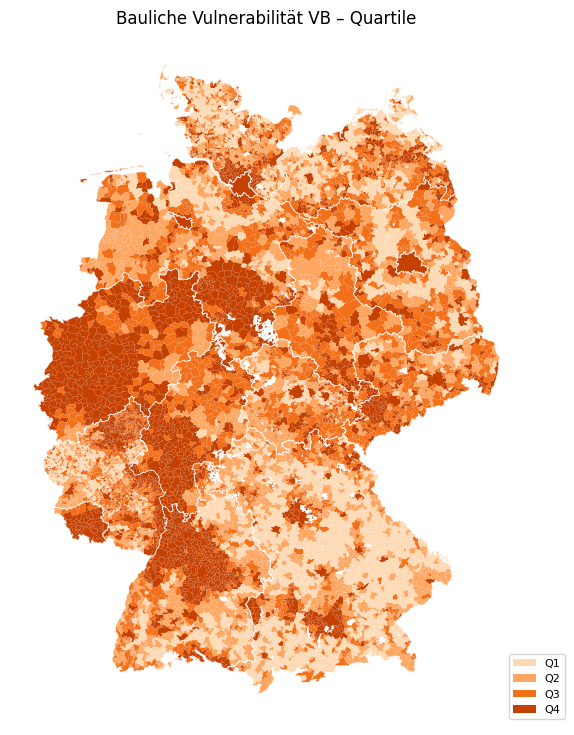

In [9]:
col = "VB_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = cp.colors_from_mpl("Oranges_r", len(labels), clip = 0.8) 
# colors = ['#2F7F64', '#F2C14E', '#B45309']
# colors = ['#009E73', '#E69F00', '#D55E00']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Bauliche Vulnerabilität VB – Quartile",
    # legend_offset_cm=1.0
)



In [ ]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"VB_Bauliche_Vulnerabilitaet_Qs.png", 
    out_dir="exports",
    dpi=300
)

In [70]:
# temp = gdf[['ARS', 'VB', 'VB_0_100']].copy()
# temp.to_csv('csv/VB.csv', index = False)

In [10]:
# pfad für geometrie
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# Geometriedaten
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")  # id_col hier nur informativ; wir joinen manuell

gemeinden = cp.load_level(vg, 'GEM')
kreise = cp.load_level(vg, 'KRS')
laender = cp.load_level(vg, 'LAN')

# Für Kreise sind die drei letzten Stellen null!
kreise['AGS8']    = kreise['ARS'].str[:5]+"000"
gemeinden['AGS8'] = gemeinden['ARS'].str[:5]+"000"

In [11]:
# daten laden

u65 = pd.read_csv(
    'csv/U65_kreise.csv',
        usecols = ['KRS1222','Kreisname','bev_ue65','hh_veink'],
    dtype={'KRS1222':'string'}
)

hh = pd.read_csv(
    'csv/HH.csv',
    dtype = {'ARS':'string'}
)

u65['ARS5'] = u65['KRS1222'].str[:5]

In [13]:
# Geometrie mit Daten mergen
gdf = gemeinden.merge(
    u65,
    left_on  = 'AGS8',
    right_on = 'KRS1222',
    how = 'inner'
).merge(
    hh,
    on = 'ARS',
    how = 'inner'
)

gdf.shape

(10737, 34)

In [14]:
gdf.columns

Index(['OBJID', 'BEGINN', 'ADE', 'GF', 'BSG', 'ARS', 'AGS', 'SDV_ARS', 'GEN_x',
       'BEZ', 'IBZ', 'BEM', 'NBD', 'SN_L', 'SN_R', 'SN_K', 'SN_V1', 'SN_V2',
       'SN_G', 'FK_S3', 'NUTS', 'ARS_0', 'AGS_0', 'WSK', 'DLM_ID', 'geometry',
       'AGS8', 'KRS1222', 'Kreisname', 'bev_ue65', 'hh_veink', 'ARS5', 'GEN_y',
       'HH'],
      dtype='object')

In [15]:
gdf['hh_z']       = cp.robust_z(-gdf['HH']).clip(lower=0)
gdf['hh_veink_z'] = cp.robust_z(-gdf['hh_veink']).clip(lower=0)
gdf['bev_ue65_z'] = cp.robust_z(gdf['bev_ue65']).clip(lower=0)

gdf['VS'] = 0.4*gdf['hh_z'] + 0.3*gdf['hh_veink_z'] + 0.3*gdf['bev_ue65_z']

gdf['VS_0_100'] = cp.scale_0_100(gdf['VS'],1,99)

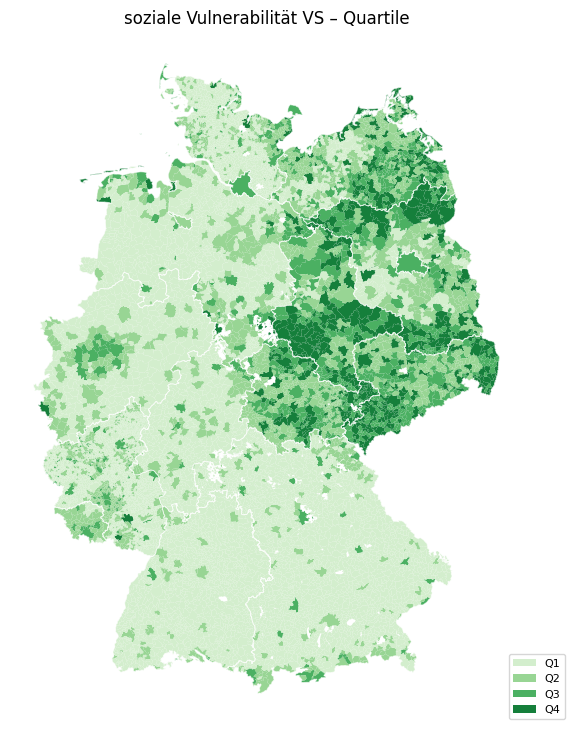

In [16]:
col = "VS_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = cp.colors_from_mpl("Greens_r", len(labels), clip = 0.8) 
# colors = ['#2F7F64', '#F2C14E', '#B45309']
# colors = ['#009E73', '#E69F00', '#D55E00']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="soziale Vulnerabilität VS – Quartile",
    # legend_offset_cm=1.0
)


In [ ]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"VS_solziale_Vulnerabilitaet_Qs.png", 
    out_dir="exports",
    dpi=300
)

In [78]:
# temp = gdf[['ARS', 'VS', 'VS_0_100']].copy()
# temp.to_csv('csv/VS.csv', index = False)

### Gesamt-Vulnerabiliität

In [17]:
# pfad für geometrie
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# Geometriedaten
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")  # id_col hier nur informativ; wir joinen manuell

gemeinden = cp.load_level(vg, 'GEM')
kreise = cp.load_level(vg, 'KRS')
laender = cp.load_level(vg, 'LAN')

In [18]:
vb = pd.read_csv(
    'csv/VB.csv',
    dtype = {'ARS':str}
)

vs = pd.read_csv(
    'csv/VS.csv',
    dtype = {'ARS':str}
)

In [19]:
gdf = gemeinden.merge(
    vb,
    on = 'ARS',
    how = 'inner').merge(
    vs,
    on = 'ARS',
    how = 'inner')
gdf.shape

(10737, 30)

### Korrelation zwischen VS und VB

In [20]:
gdf[['VS','VB']].corr(method = 'pearson')

,VS,VB
VS,1.000000,0.156057
VB,0.156057,1.000000


In [21]:
gdf['VUL'] = 0.6*gdf['VB'] + 0.4*gdf['VS']
gdf['VUL_0_100']=cp.scale_0_100(gdf['VUL'],1,99)

### VUL plotten

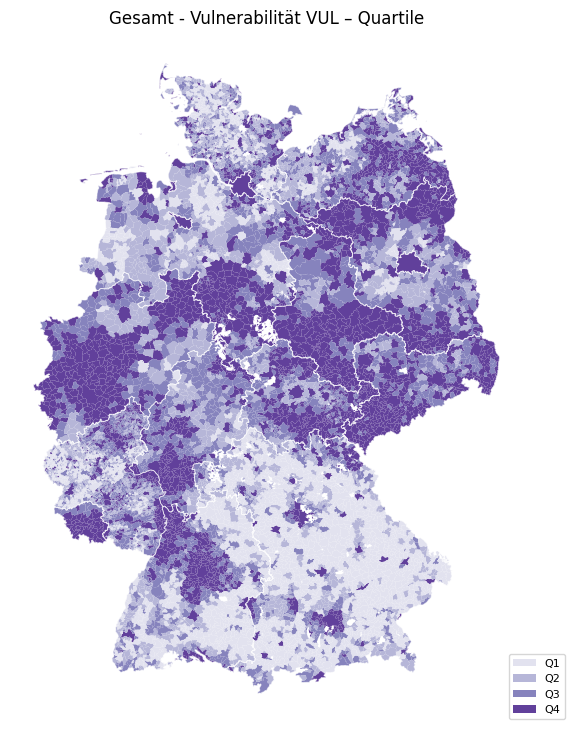

In [22]:
col = "VUL_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = cp.colors_from_mpl("Purples_r", len(labels), clip = 0.8) 
# colors = ['#2F7F64', '#F2C14E', '#B45309']
# colors = ['#009E73', '#E69F00', '#D55E00']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Gesamt - Vulnerabilität VUL – Quartile",
    # legend_offset_cm=1.0
)

In [125]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"VUL_Qs.png", 
    out_dir="exports",
    dpi=300
)


### Mit q90 Kontur

In [23]:
col = "VUL_0_100"  

# 90% Quantil-Schwelle berechnen
q90 = gdf[col].quantile(0.90)
gdf_hot = gdf[gdf[col] > q90].copy().dissolve()

<Axes: title={'center': 'Gesamt - Vulnerabilität VUL – Quartile'}>

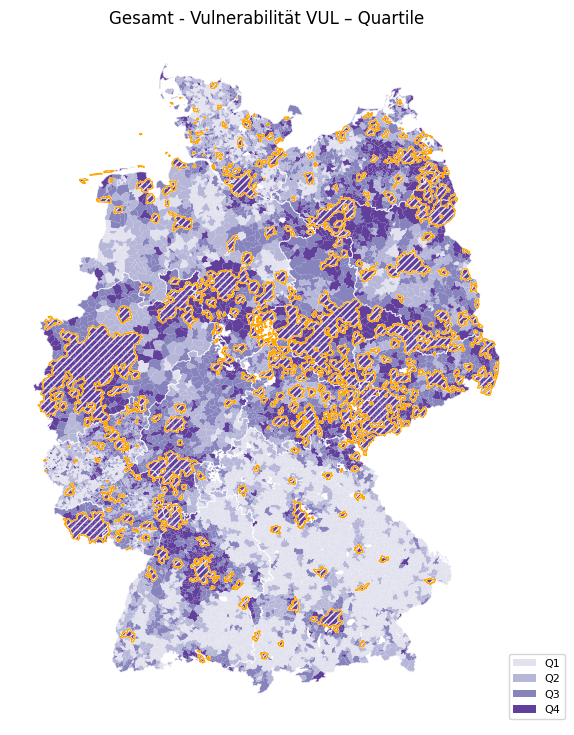

In [24]:
col = "VUL_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = cp.colors_from_mpl("Purples_r", len(labels), clip = 0.8) 
# colors = ['#2F7F64', '#F2C14E', '#B45309']
# colors = ['#009E73', '#E69F00', '#D55E00']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Gesamt - Vulnerabilität VUL – Quartile",
    # legend_offset_cm=1.0
)
# heiße zone = q90
gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '/////',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'orange',
    linewidth = 0.8,
)

In [128]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"VUL_Qs_q90_contour.png", 
    out_dir="exports",
    dpi=300
)


In [129]:
# temp = gdf[['ARS', 'VUL', 'VUL_0_100']]
# temp.to_csv('csv/VUL.csv', index = False)